# Management and Analysis of Physics Dataset - mod.B

## Final project: Streaming processing of cosmic rays using Drift Tubes detectors

The goal of this project is to reproduce a real-time processing of real data collected in a particle physics detector and publish the results in a dashboard for live monitoring.

### Students:
* Conforto Filippo (2021856)
* Domenichetti Lorenzo (2011653)
* Faorlin Tommaso (2021857)

# Dashboard  Notebook

In [1]:
import json
import pylab as pl
import numpy as np

from IPython import display

from kafka import KafkaConsumer
from kafka.admin import KafkaAdminClient

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Kafka server

In [2]:
#define the kafka server from IP and Port
KAFKA_BOOTSTRAP_SERVERS='slave04:9092'

#consumer definition from IP address given before
consumer = KafkaConsumer(bootstrap_servers=KAFKA_BOOTSTRAP_SERVERS, consumer_timeout_ms=100000)

#consumer subscription to topic_results
consumer.subscribe('topic_results')

#Additional configuration options for consumer
consumer.poll(timeout_ms=0,         # do not enable dead-times before one poll to the next
              max_records=None,     # do not limit the number of records to consume at once 
              update_offsets=True   # update the reading offsets on this topic
             )

{}

## Visualization functions

In [3]:
def rt_plot(js,num, fig,axes):
    
    #to delete the texts written during the previous update
    for txt in fig.texts:
        txt.set_visible(False)
    
    #label with informations on the right side of the window
    plt.figtext(1.01, 0.5, f'Batch N° {num}:\n\nHits: {js["hits"]} \n\n' + f'Channel 0: {js["hits_per_chamber"][0]} hits\n\n' + f'Channel 1: {js["hits_per_chamber"][1]} hits\n\n' + f'Channel 2: {js["hits_per_chamber"][2]} hits\n\n' + f'Channel 3: {js["hits_per_chamber"][3]} hits' 
                , ha='left', va='center', fontsize = 20, 
               bbox=dict(facecolor='snow', edgecolor='black', boxstyle='round'))
    
    #main title of the upper panel
    plt.figtext(0.5, 1.07, f'Muon-Hits Monitors', ha='center', va='center', fontsize = 30)
    plt.figtext(0.5, 1.025, f'Total active channels', ha='center', va='center', fontsize = 22)
      
    #main title of the second panel
    plt.figtext(0.5, 0.75, 'Total number of active channels per orbit', ha='center', va='center', fontsize = 22)
            
    #main title of the third panel
    plt.figtext(0.5, 0.5, f'Total active channels for orbits with active scintillator', ha='center', va='center', fontsize = 22)
    
    #main title of the lower panel
    plt.figtext(0.5, 0.24, 'Drift time', ha='center', va='center', fontsize = 22)
    
    for j,xlab,histo in zip([0,1,2,3],["Channel N°","Orbit N°","Channel N°","Time[ns]"],["hist_1", "hist_2", "hist_3","hist_4"]):

        for i, ax in enumerate(axes[j]):
            #clean previous plots and update titles and labels
            ax.clear()
            ax.set_title(f'Chamber {i}', fontsize=15)
            ax.set_xlabel(xlab,  fontsize=14)
            if i==0:
                ax.set_ylabel("Counts",  fontsize=14)
            #bins centers computation
            bin_centers = js[histo][str(i)]["bins"][:-1] + np.diff(js[histo][str(i)]["bins"])/2
            ax.hist(bin_centers, weights=js[histo][str(i)]["counts"], bins=js[histo][str(i)]["bins"], alpha=0.6)
            ax.tick_params(labelsize=13)

    #to separate better the plots
    plt.tight_layout(h_pad = 7, w_pad = 1)
    
    #clean the whole screen and update with new incoming data
    display.clear_output(wait=True)
    display.display(pl.gcf())

def bin_sum(old_j,new_j):
    #updating old values 
    for i,name in enumerate(["hits","hits_per_chamber","hist_1","hist_2","hist_3","hist_4"]):
            if i==0:
                #to add new hits
                old_j[name]+=new_j[name]
            elif i==1:
                #to add new hits per chamber
                old_j[name]=np.asarray(old_j[name]) + np.asarray(new_j[name])
            else:
                for j in range(4):
                    #to update counts with the incoming data array
                    old_j[name][str(j)]["counts"]=np.asarray(old_j[name][str(j)]["counts"]) + np.asarray(new_j[name][str(j)]["counts"])


## Cumulative dashboard service

KeyboardInterrupt: 

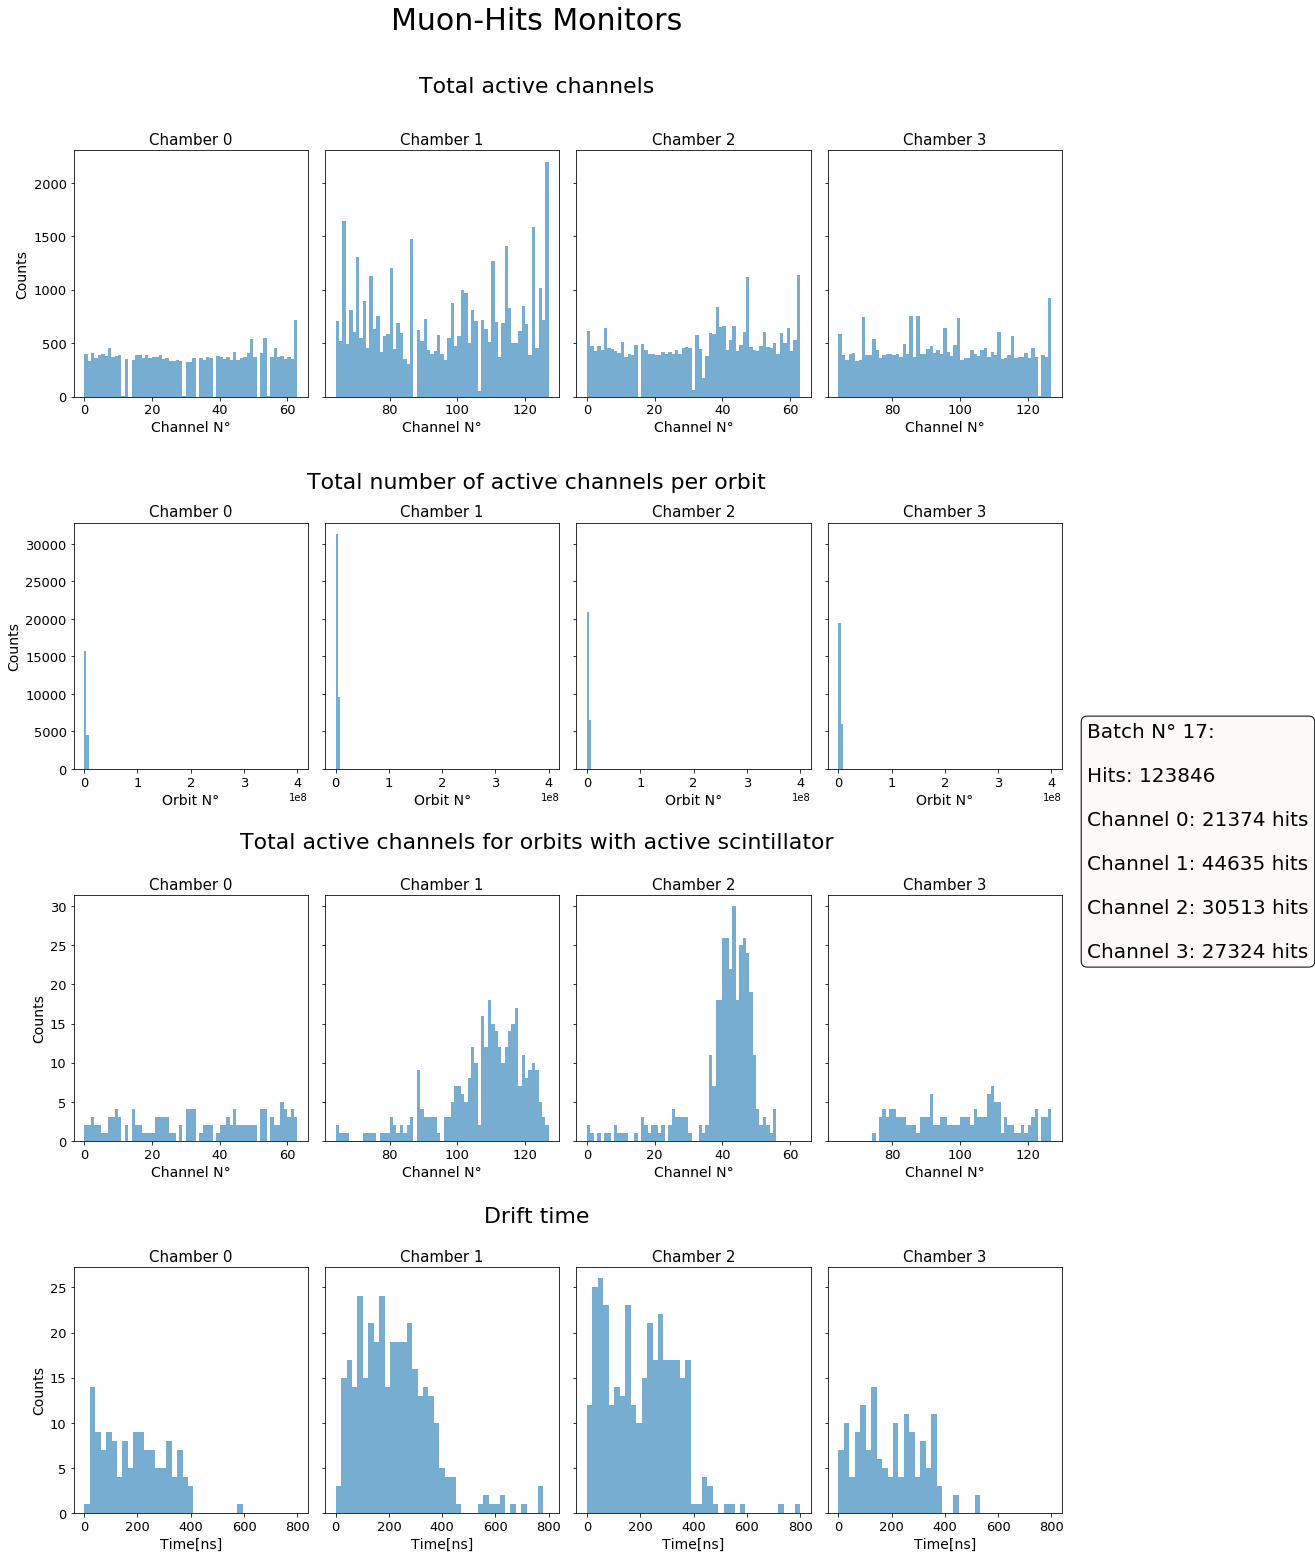

In [4]:
#Figure creation
fig, axes = plt.subplots(4,4, figsize = (15,20), sharey = 'row')
for num,message in enumerate(consumer):
    if num==0:
        #The first incoming message is simply stored
        msg = json.loads(message.value)
    else: 
        #The messages following are obtained as an update of the first one
        bin_sum(msg,json.loads(message.value))
    #plot production
    rt_plot(msg,num,fig,axes)

## Single-batch dashboard service

KeyboardInterrupt: 

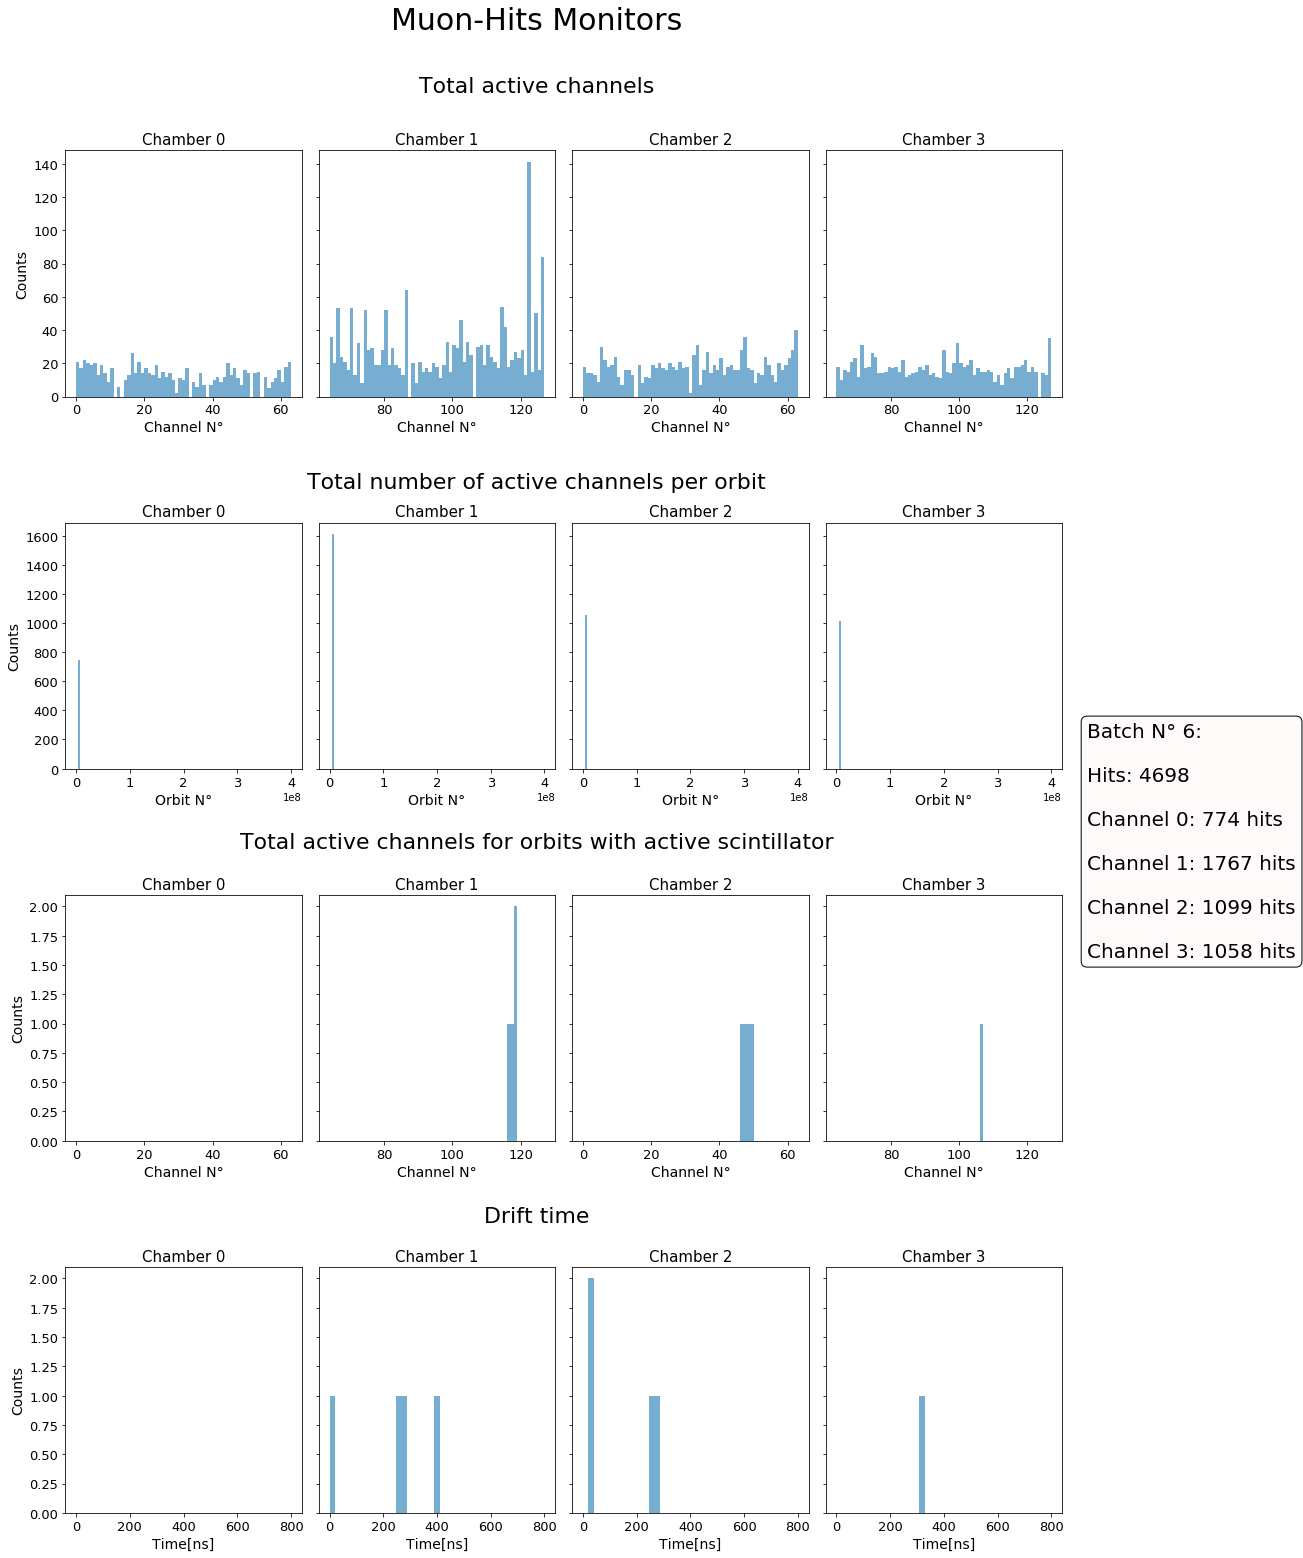

In [5]:
#Figure creation
fig, axes = plt.subplots(4,4, figsize = (15,20), sharey = 'row')
for num,message in enumerate(consumer):
    #Creating and plotting values for the received message
    msg = json.loads(message.value)
    rt_plot(msg,num,fig,axes)